In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import torch.nn.functional as FNT


In [38]:


######################################################
#
#  outils d'affichage -  NE PAS TOUCHER

def ComputeCatPerPixel(XX,YY, weights):
    CategoriePerPixel = XX.copy()
    Larg,Haut = XX.shape
    for i in range(Larg):
        for j in range(Haut):
            x = XX[i][j]
            y = YY[i][j]
            score = compute_single_score(x, y, weights)
            CategoriePerPixel[i][j] = determine_cat(score)
    return CategoriePerPixel

def DessineFond(weights):
    iS = ComputeCatPerPixel(XXXX,YYYY, weights)
    levels = [-1, 0, 1, 2]
    c1 = ('r', 'g', 'b')
    plt.contourf(XXXX, YYYY, iS, levels, colors = c1)

def DessinePoints(x, y, cats):
    c2 = ('darkred','darkgreen','lightblue')
    c = [c2[cat] for cat in cats.numpy()]
    plt.scatter(x.numpy(), y.numpy() ,  s=50, c=c,  marker='o')



##############################################################
#
#  PROJET

# Chaque échantillon a 2 caractéristiques : x et y
# Nous devons apprendre à deviner la catégorie : 0 1 ou 2 suivant ce couple (x,y)

# Pour chaque catégorie i, nous avons 3 paramètres ai, bi, ci d'apprentissage
# Pour un couple (x,y), nous calculons un score pour chaque catégorie :
# ScoreCat0 = a0 * x + b0 * y + c0   (équivaut à 1 neuronne)
# ScoreCat1 = a1 * x + b1 * y + c1   (équivaut à 1 neuronne)
# ScoreCat2 = a2 * x + b2 * y + c2   (équivaut à 1 neuronne)

# Plus simplement :
#         Scores = W . (x,y,1)    W représente 3 neurones, chaque neurone a 3 paramètres internes

# Le plus fort score est associé à la catégorie retenue

# Pour calculer l'erreur, on prend le score Sk de la vrai catégorie k de l'échantillon.
# On calcule Err = Sigma_(j=0 à nb_cat) max(0,Sj - Sk)  avec Sj score de la cat j

# Comment interpréter cette formule :
# La grandeur Sj-Sk nous donne l'écart entre le score de la bonne catégorie et le score de la cat j.
# Si j correspond à k, la contribution à l'erreur vaut 0, on ne tient pas compte de la valeur Sj=k dans l'erreur
# Sinon Si cet écart est positif, ce n'est pas bon signe, car cela sous entend que le plus grand
#          score ne correspond pas à la bonne catégorie et donc on obtient un malus.
#          Plus le mauvais score est grand? plus le malus est important.
#       Si cet écart est négatif, cela sous entend que le score de la bonne catégorie est supérieur
#          au score de la catégorie courante. Tout va bien. Mais il ne faut pas que cela influence
#          l'erreur car l'algorithme doit corriger les mauvaises prédictions. Pour cela, max(0,.)
#          permet de ne pas tenir compte de cet écart négatif dans l'erreur.



In [66]:
def determine_cat(scores):
    return torch.argmax(scores, dim=0)

def compute_single_score(x, y, weights):
    vec    = torch.tensor([x, y, 1], dtype=dtype)
    score  = torch.matmul(weights, vec) # multiplication matricielle sinon broadcasting
    return score


def compute_scores(x, y, weights):
    if x.size() != y.size():
        raise ArgumentException()
    vecs = torch.empty(3, x.size()[0], dtype=dtype)
    vecs[0] = x
    vecs[1] = y
    vecs[2] = torch.ones(x.size())
    scores  = torch.matmul(weights, vecs) # multiplication matricielle sinon broadcasting
    return scores

def compute_cat_prob(x, y, weights):
    scores = compute_scores(x, y, weights)
    # normalising to [-1, 1]
    scores = (2 / np.pi) * torch.atan(scores)
    # On second thought, we should not clamp.
    # Clamping messes up the automatic gradiant computations
    # and prevents introducing back a category 
    # if it has previously been discarded:
    # If a colour, half-plane etc. disappears,
    # it wouldn't come back.
    return scores
    
def compute_cat_truths(cats, number_cats):
    cat_probs = torch.zeros((number_cats, cats.size()[0]))
    for i in range(len(cats)):
        cat_probs[cats[i].item(), i] = 1.
    return cat_probs


In [62]:
######################################################

# (x,y, category)
data = [[0.5,0.4,0],
        [0.8,0.3,0],
        [0.3,0.8,0],
        [-.4,0.3,1],
        [-.3,0.7,1],
        [-.7,0.2,1],
        [-.4,-.5,1],
        [0.7,-.4,2],
        [0.5,-.6,2]]


XXXX , YYYY = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))



In [63]:
####################################################################

layer_func = lambda weights : lambda x, y : compute_cat_prob(x, y, weights)
loss_func  = lambda cat_truths, cat_probs_pred  : torch.maximum(torch.zeros_like(cat_probs_pred), cat_truths - cat_probs_pred).sum()

dtype = torch.float64

In [64]:
data_tens = torch.tensor(data)

# (x,y, category)
points = data_tens[:, :2]
cats   = data_tens[:, 2].int()

x_train = points[:, 0]
y_train = points[:, 1]
cat_truths = compute_cat_truths(cats, 3)

learning_rate = 1

weights = torch.randn((3,3), dtype=dtype, requires_grad=True)


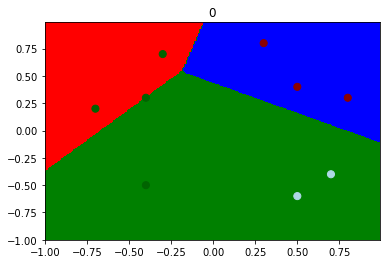

tensor([[-0.6861, -0.7761, -0.3964,  0.0301,  0.2940,  0.3298, -0.5862, -0.8314,
         -0.8259],
        [ 0.2444,  0.3593, -0.0074,  0.0205, -0.1458, -0.0249,  0.3728,  0.5402,
          0.5558],
        [ 0.4047,  0.5192,  0.4085, -0.2982, -0.0664, -0.4889, -0.5147,  0.2735,
          0.0390]], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


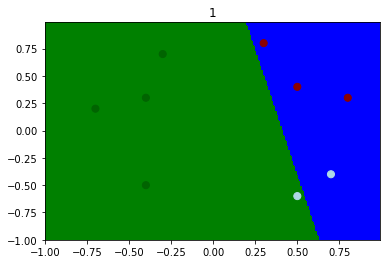

tensor([[-0.3841, -0.6281,  0.3013,  0.4993,  0.6392,  0.6114, -0.3289, -0.7721,
         -0.7700],
        [ 0.8146,  0.8073,  0.8231,  0.8294,  0.8320,  0.8331,  0.8204,  0.7996,
          0.8011],
        [ 0.8277,  0.8410,  0.8272,  0.7507,  0.7805,  0.7033,  0.6981,  0.8169,
          0.7960]], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


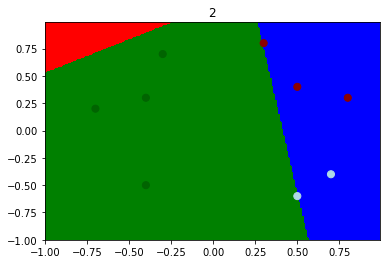

tensor([[ 0.6088,  0.3844,  0.7710,  0.7735,  0.8196,  0.7929,  0.4571, -0.4030,
         -0.4502],
        [ 0.8222,  0.8141,  0.8312,  0.8387,  0.8412,  0.8429,  0.8297,  0.8063,
          0.8083],
        [ 0.8332,  0.8467,  0.8311,  0.7571,  0.7843,  0.7103,  0.7129,  0.8259,
          0.8069]], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


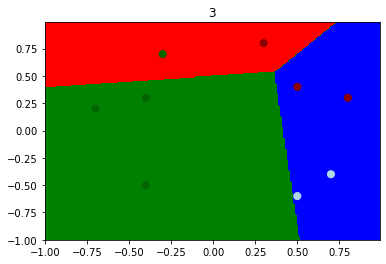

tensor([[0.8154, 0.7899, 0.8565, 0.8355, 0.8630, 0.8355, 0.7114, 0.6211, 0.5547],
        [0.8285, 0.8198, 0.8379, 0.8462, 0.8486, 0.8507, 0.8372, 0.8119, 0.8143],
        [0.8379, 0.8514, 0.8345, 0.7625, 0.7876, 0.7163, 0.7251, 0.8334, 0.8159]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


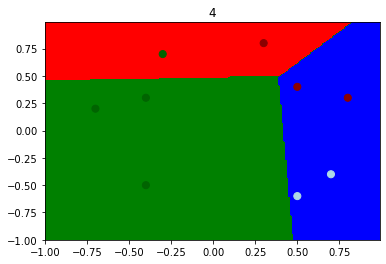

tensor([[0.8263, 0.8049, 0.8635, 0.8409, 0.8678, 0.8396, 0.7211, 0.6555, 0.5928],
        [0.8339, 0.8247, 0.8436, 0.8525, 0.8548, 0.8572, 0.8436, 0.8167, 0.8194],
        [0.8420, 0.8556, 0.8375, 0.7673, 0.7906, 0.7217, 0.7354, 0.8396, 0.8234]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


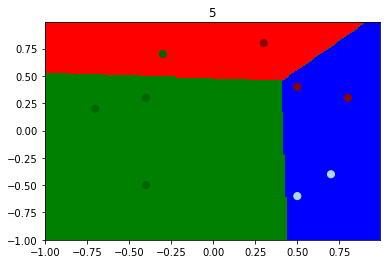

tensor([[0.8349, 0.8166, 0.8691, 0.8454, 0.8718, 0.8431, 0.7291, 0.6813, 0.6219],
        [0.8386, 0.8289, 0.8485, 0.8579, 0.8600, 0.8627, 0.8490, 0.8210, 0.8240],
        [0.8456, 0.8592, 0.8402, 0.7715, 0.7932, 0.7264, 0.7444, 0.8450, 0.8298]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


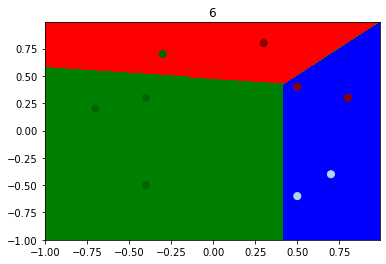

tensor([[0.8420, 0.8259, 0.8738, 0.8493, 0.8751, 0.8461, 0.7360, 0.7017, 0.6450],
        [0.8427, 0.8328, 0.8527, 0.8625, 0.8646, 0.8675, 0.8537, 0.8248, 0.8280],
        [0.8488, 0.8624, 0.8426, 0.7754, 0.7957, 0.7307, 0.7522, 0.8498, 0.8354]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


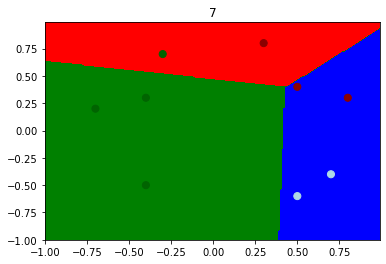

tensor([[0.8479, 0.8337, 0.8778, 0.8527, 0.8781, 0.8488, 0.7420, 0.7182, 0.6640],
        [0.8463, 0.8362, 0.8565, 0.8666, 0.8686, 0.8716, 0.8579, 0.8282, 0.8316],
        [0.8516, 0.8653, 0.8448, 0.7789, 0.7979, 0.7346, 0.7591, 0.8539, 0.8404]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


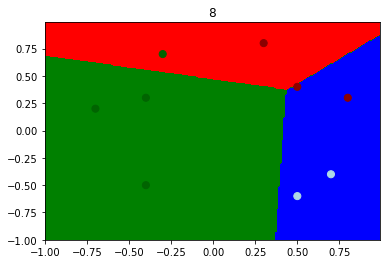

tensor([[0.8530, 0.8403, 0.8813, 0.8557, 0.8807, 0.8512, 0.7474, 0.7321, 0.6800],
        [0.8497, 0.8393, 0.8599, 0.8703, 0.8722, 0.8753, 0.8616, 0.8313, 0.8348],
        [0.8543, 0.8679, 0.8469, 0.7821, 0.8000, 0.7382, 0.7653, 0.8577, 0.8448]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


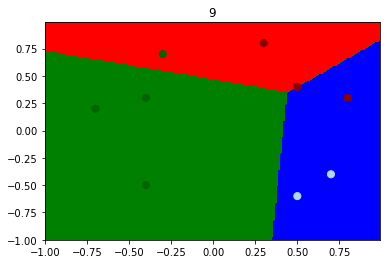

tensor([[0.8575, 0.8460, 0.8844, 0.8584, 0.8830, 0.8534, 0.7522, 0.7438, 0.6936],
        [0.8527, 0.8421, 0.8630, 0.8735, 0.8754, 0.8786, 0.8650, 0.8341, 0.8378],
        [0.8567, 0.8703, 0.8487, 0.7850, 0.8019, 0.7415, 0.7710, 0.8611, 0.8487]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


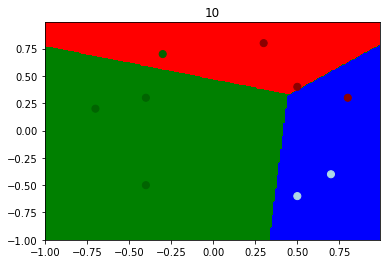

tensor([[0.8615, 0.8510, 0.8872, 0.8608, 0.8851, 0.8554, 0.7565, 0.7540, 0.7055],
        [0.8554, 0.8447, 0.8658, 0.8765, 0.8783, 0.8816, 0.8680, 0.8368, 0.8406],
        [0.8589, 0.8725, 0.8505, 0.7878, 0.8037, 0.7446, 0.7761, 0.8641, 0.8523]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


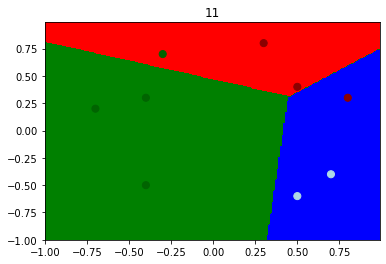

tensor([[0.8651, 0.8555, 0.8896, 0.8630, 0.8871, 0.8572, 0.7605, 0.7629, 0.7159],
        [0.8579, 0.8471, 0.8684, 0.8792, 0.8809, 0.8843, 0.8708, 0.8392, 0.8431],
        [0.8610, 0.8746, 0.8521, 0.7903, 0.8054, 0.7475, 0.7808, 0.8670, 0.8556]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


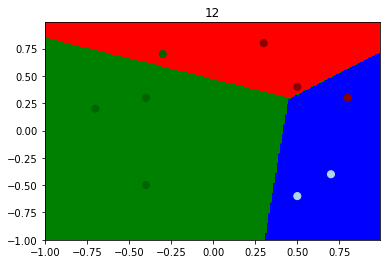

tensor([[0.8683, 0.8595, 0.8919, 0.8651, 0.8889, 0.8589, 0.7641, 0.7708, 0.7252],
        [0.8603, 0.8493, 0.8707, 0.8817, 0.8834, 0.8868, 0.8734, 0.8414, 0.8454],
        [0.8629, 0.8765, 0.8537, 0.7927, 0.8070, 0.7502, 0.7851, 0.8695, 0.8586]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


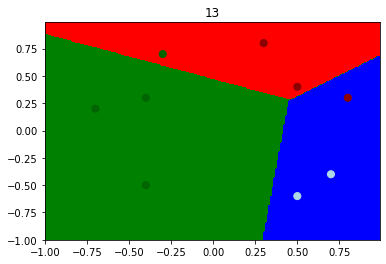

tensor([[0.8712, 0.8630, 0.8940, 0.8670, 0.8905, 0.8605, 0.7675, 0.7779, 0.7334],
        [0.8625, 0.8514, 0.8729, 0.8839, 0.8856, 0.8891, 0.8757, 0.8435, 0.8476],
        [0.8647, 0.8782, 0.8551, 0.7950, 0.8085, 0.7528, 0.7891, 0.8719, 0.8614]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


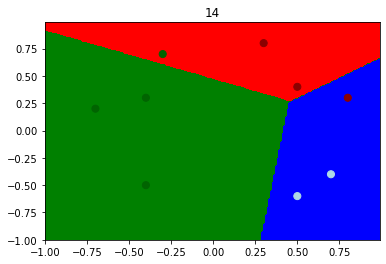

tensor([[0.8739, 0.8663, 0.8959, 0.8688, 0.8920, 0.8620, 0.7706, 0.7843, 0.7409],
        [0.8645, 0.8534, 0.8750, 0.8861, 0.8877, 0.8912, 0.8779, 0.8455, 0.8497],
        [0.8664, 0.8799, 0.8565, 0.7971, 0.8099, 0.7552, 0.7928, 0.8742, 0.8640]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


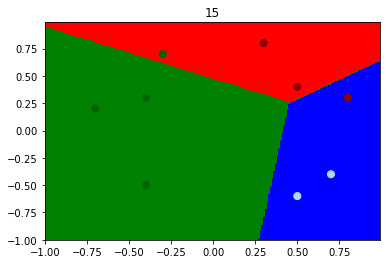

tensor([[0.8763, 0.8693, 0.8976, 0.8704, 0.8934, 0.8634, 0.7736, 0.7900, 0.7477],
        [0.8664, 0.8552, 0.8769, 0.8880, 0.8896, 0.8932, 0.8800, 0.8474, 0.8516],
        [0.8680, 0.8814, 0.8578, 0.7991, 0.8113, 0.7575, 0.7962, 0.8762, 0.8664]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


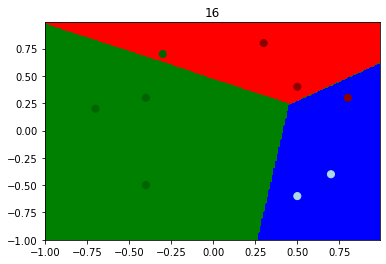

tensor([[0.8786, 0.8720, 0.8993, 0.8720, 0.8948, 0.8647, 0.7763, 0.7953, 0.7540],
        [0.8682, 0.8569, 0.8787, 0.8899, 0.8914, 0.8950, 0.8819, 0.8491, 0.8534],
        [0.8695, 0.8829, 0.8590, 0.8010, 0.8126, 0.7597, 0.7995, 0.8782, 0.8686]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


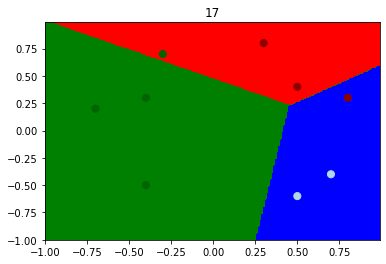

tensor([[0.8807, 0.8746, 0.9008, 0.8735, 0.8960, 0.8659, 0.7789, 0.8001, 0.7597],
        [0.8699, 0.8586, 0.8804, 0.8916, 0.8931, 0.8968, 0.8837, 0.8508, 0.8552],
        [0.8709, 0.8843, 0.8602, 0.8029, 0.8138, 0.7617, 0.8025, 0.8800, 0.8707]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


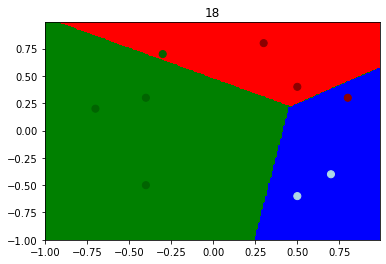

tensor([[0.8827, 0.8769, 0.9023, 0.8748, 0.8972, 0.8671, 0.7814, 0.8046, 0.7650],
        [0.8715, 0.8601, 0.8819, 0.8932, 0.8947, 0.8984, 0.8854, 0.8524, 0.8568],
        [0.8722, 0.8856, 0.8613, 0.8046, 0.8150, 0.7637, 0.8054, 0.8817, 0.8727]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


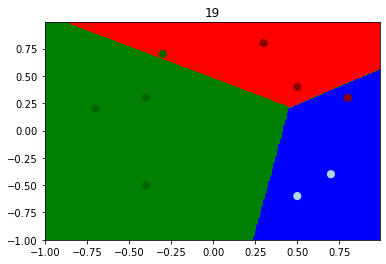

tensor([[0.8845, 0.8791, 0.9036, 0.8761, 0.8983, 0.8682, 0.7837, 0.8087, 0.7699],
        [0.8730, 0.8616, 0.8834, 0.8947, 0.8962, 0.8999, 0.8869, 0.8539, 0.8583],
        [0.8735, 0.8868, 0.8623, 0.8062, 0.8161, 0.7656, 0.8081, 0.8834, 0.8745]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])


In [65]:

for epoch in range(20):

    DessineFond(weights)
    DessinePoints(x_train, y_train, cats)

    plt.title(str(epoch))
    plt.pause(2)  # pause avec duree en secondes

    # W = torch.randn((3,3)) # juste pour animer au début, cette ligne doit disparaitre
    
    layer = layer_func(weights)
    
    cat_probs_pred = layer(x_train, y_train)
    
    loss = loss_func(cat_truths, cat_probs_pred)
    
    # A chaque itération, affichez la valeur de a et de l'erreur totale
    # print("--- epoch {0} : loss = {1}".format(epoch, loss.item()))
    
    # Passe BACKWARD :
    # Lorsque le calcul de la passe Forward est terminé,
    # nous devons lancer la passe Backward pour calculer le gradient.
    # Le calcul du gradient est déclenché par la syntaxe :
        
    loss.backward()

    # GRADIENT DESCENT :
    # Effectuez la méthode de descente du gradient pour modifier la valeur
    # du paramètre d'apprentissage a. Etrangement, il faut préciser à Pytorch
    # d'arrêter de calculer le gradient de a en utilisant la syntaxe ci-après.
    # De plus, il faut réinitialiser le gradient de a à zéro manuellement :

    with torch.no_grad() :
        weights -= learning_rate * weights.grad
        weights.grad.zero_()


plt.show()

### Exercice 2

In [67]:


##############################################################
#
#  PROJETS

# chaque échantillon a 2 caractéristiques : x et y
# nous devons apprendre à deviner la catégorie : 0 1 ou 2 pour un couple (x,y)

# extension du cas précédent : Scores = [ x,y,1] * W
# à un calcul en deux étapes :

# T = [x,y,1] * W1
# T = Relu(T)         # on ne garde que les valeurs positives
# Scores = T * W2



# ==============================================


# o La fonction Relu est déjà fourni dans pytorch : torch.nn.functional.relu
# o Pensez à réduire le pas si l'erreur oscille
# o Lancez un affichage toutes les 50 itérations, car l'affichage prend du temps

# =======================================================

# On se propose de travailler avec 2 couches de neurones :
# Input => W1x => Relu => W2x => Scores

# CONSEIL 1
# Si l'on garde pour W1 juste 3 neuronnes, cela ne marchera pas car le reseau n'est pas passez puissant pour apprendre la forme
# => Mettre plusieurs neuronnes sur la couche 1 : à tester  10 / 30 / 100 / 300 / 500 / 1000
# OU (à tester)
# => Garder 3 neuronnes, mais avec plus de poids (paramètre interne)

# CONSEIL 2
# Les scores en sortie peuvent être proches : 3.1 3.2 3.3, ainsi le best score n'est pas vraiment qualitatif.
# On va améliorer la fonction erreur pour qu'elle force le best score à etre plusieurs points au dessus des autres.

# Pour cela, au lieu de faire :
#    Err = Sigma_(j=0 à nb_cat) max(0,Sj-Sk)  avec Sj score de la cat j et Sk score de la bonne catégorie,

# Nous allons choisir :
#    Err = Sigma_(j=0 à nb_cat) max(0,(Sj+2)-Sk) par exemple

# Ainsi, la contribution à l'erreur vaut 0 lorsque Sk > Sj + 2 (il y a deux points d'écart minimum)


In [ ]:
# (x,y,category)
points= []
N = 30    # number of points per class
K = 3     # number of classes
for i in range(N):
   r = i / N
   for k in range(K):
      t = ( i * 4 / N) + (k * 4) + random.uniform(0,0.2)
      points.append( [ ( r*math.sin(t), r*math.cos(t) ) , k ] )

In [68]:
W = torch.randn((3,3), requires_grad=True)

for i in range(20):

    DessineFond()
    DessinePoints()

    plt.title(str(i))
    plt.pause(2)  # pause avec duree en secondes

plt.show()


TypeError: DessineFond() missing 1 required positional argument: 'weights'